Robustness calculation using multi-scenario MORDM

First we import all the packages we need and formulate the problem. We have chosen to use problem formulation 3, however this has been changed in the problemformulation.py file. So it only uses the outcomes relevant for our problem owner, mainly specific outcomes for the dike ring 5, around deventer, and the room for the river and evacuation costs. We then also select certain policies to start of the first analysis. This is 0-policy without any levers being used, and the a policy which sets the dike heigths at the other dike rings, and lastly a policy that sets the dike higths and triggers the room for the rover projects at all places besides dike ring 5.

In [ ]:
#importing packages
from ema_workbench import (
    Policy,
    ema_logging,
    MultiprocessingEvaluator,
    ScalarOutcome
)

import problem_formulation
from importlib import reload 

reload(problem_formulation) # this is used to reload the problemformulation.py so the changes made there are registered.
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(3)

import copy
#Here we print the uncertainties, levers and outcomes, to check them
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)
for outcome in dike_model.outcomes:
    print(repr(outcome))

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

#Here the policies for the start analysis are defined
policies = [
    Policy(
        "policy 1", #nothing policy
        **dict(
            get_do_nothing_dict(),
        )
    ),
    Policy(
        "policy 2", # dike increase policy
        **dict(
            get_do_nothing_dict(),
            **{"A.1_DikeIncrease 0": 5, "A.2_DikeIncrease 0": 5, "A.3_DikeIncrease 0": 5, "A.4_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 3", #dike increase and room for the river policy
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 1": 1, "2_RfR 1": 1, "3_RfR 1": 1, "5_RfR 1": 1, "A.1_DikeIncrease 0": 5, "A.2_DikeIncrease 0": 5, "A.3_DikeIncrease 0": 5, "A.4_DikeIncrease 0": 5}
        )
    ),
]

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [2]:
#running the model for the first time as a starting point for the further analysis
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 100 scenarios * 3 policies * 1 model(s) = 300 experiments
100%|████████████████████████████████████████| 300/300 [00:32<00:00,  9.17it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
experiments, outcomes = results

In the next part we select the worst scenarios to do the further MORDM analysis with. This is because the problem owner will want to minimise the worst outcomes.

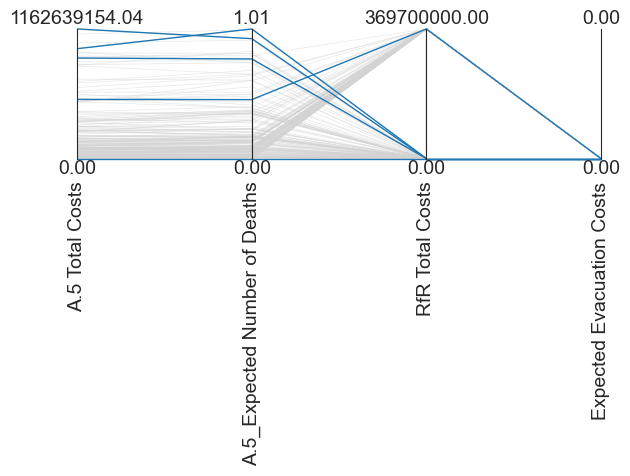

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench.analysis import parcoords

all_data = pd.DataFrame({k:v for k,v in outcomes.items()})

# let's get the unique indices for the minima and maxima across 
# all objectives
indices = pd.concat([all_data.idxmax(), all_data.idxmin()]).unique()

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(all_data, color='lightgrey', lw=0.5, alpha=0.5)
axes.plot(all_data.iloc[indices, :], color=sns.color_palette()[0], lw=1)

fig = plt.gcf()

plt.show()

Explain results

In [6]:
print(all_data.idxmax())
print(all_data.idxmax().unique().tolist())
experimentlist = all_data.idxmax().unique().tolist()
experimentlist.remove(0)
print(experimentlist)

A.5 Total Costs                  139
A.5_Expected Number of Deaths    127
RfR Total Costs                  200
Expected Evacuation Costs          0
dtype: int64
[139, 127, 200, 0]
[139, 127, 200]


In [7]:
# also all we need are the uncertainty columns, and we select the scenarios that are the worst
selected = experiments.loc[experimentlist, ['A.1_pfail', 'A.1_Bmax', 'A.1_Brate', 'A.2_pfail', 'A.2_Bmax', 'A.2_Brate','A.3_pfail', 'A.3_Bmax', 'A.3_Brate','A.4_pfail', 'A.4_Bmax', 'A.4_Brate','A.5_pfail', 'A.5_Bmax', 'A.5_Brate', 'discount rate 0','discount rate 1','discount rate 2','A.0_ID flood wave shape']]
selected

,A.1_pfail,A.1_Bmax,A.1_Brate,A.2_pfail,A.2_Bmax,A.2_Brate,A.3_pfail,A.3_Bmax,A.3_Brate,A.4_pfail,A.4_Bmax,A.4_Brate,A.5_pfail,A.5_Bmax,A.5_Brate,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape
139,0.589177,222.648314,10.0,0.184966,318.968096,1.5,0.783211,160.293888,1.5,0.784900,327.632586,10.0,0.014259,61.767070,10.0,1.5,3.5,2.5,85
127,0.212603,195.928050,1.0,0.112629,118.142661,1.0,0.967013,228.186183,1.0,0.186670,290.689262,1.5,0.030438,239.843170,1.5,4.5,3.5,2.5,50
200,0.561693,340.345709,1.0,0.666079,329.313781,1.0,0.597022,123.835268,1.0,0.501881,117.945418,10.0,0.072357,303.187951,1.0,2.5,4.5,1.5,16


In [8]:
#Then we make it into actual scenario objects
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

The next part is actually running the model with these scenarios. We had to hotfix/monkeypatch some code from the original model, as the vairbales containt spaces which could not be used in the normal EMA/platypus code.

In [9]:
from ema_workbench import MultiprocessingEvaluator, ema_logging

from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated)

ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench.em_framework import optimization

def transform_variables_fixed(problem, variables):
    converted_vars = []
    for type, var in zip(problem.types, variables):
        if isinstance(var, (list, tuple)):
            var = type.decode(var)
            try:
                var = var[0]
            except TypeError:
                pass
        converted_vars.append(var)
    return converted_vars
from ema_workbench.em_framework import optimization
from ema_workbench.util.ema_exceptions import EMAError
from platypus import Solution

def rebuild_platypus_population_fixed(archive, problem):
    solutions = []

    for _, row in archive.iterrows():
        try:
            decision_variables = [row[attr] for attr in problem.parameter_names]
        except KeyError:
            missing_parameters = [attr for attr in problem.parameter_names if attr not in row]
            raise EMAError(f"Parameter names {missing_parameters} not found in archive")

        try:
            objectives = [row[attr] for attr in problem.outcome_names]
        except KeyError:
            missing_outcomes = [attr for attr in problem.outcome_names if attr not in row]
            raise EMAError(f"Outcome names {missing_outcomes} not found in archive")

        solution = Solution(problem)

        # ✅ the clean, warning-free way:
        solution.variables[:] = decision_variables
        solution.objectives[:] = objectives

        solutions.append(solution)

    return solutions

# Monkeypatch the function
optimization.rebuild_platypus_population = rebuild_platypus_population_fixed
optimization.transform_variables = transform_variables_fixed
def optimize(scenario, nfe, model, epsilons):
    results = []
    convergences = []
    problem = to_problem(model, searchover="levers")

    with MultiprocessingEvaluator(model) as evaluator:
        for i in range(5):
            convergence_metrics = [
                ArchiveLogger(
                    "./archives",
                    [l.name for l in model.levers],
                    [o.name for o in model.outcomes],
                    base_filename=f"assignment_final_{scenario.name}_seed_{i}.tar.gz",
                ),
                EpsilonProgress(),
            ]

            result, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                         convergence=convergence_metrics,
                                         epsilons=epsilons,
                                         reference=scenario)

            results.append(result)
            convergences.append(convergence)
    
    # merge the results using a non-dominated sort  
    reference_set = epsilon_nondominated(results, epsilons, problem)
    
    return reference_set, convergences


results = []
for scenario in scenarios:
    epsilons = [0.25,]*len(dike_model.outcomes)
    
    # note that the nfe is again rather low to ensure proper convergence, however runtime consideration limit how large this can be to ensure actually getting some results
    results.append(optimize(scenario, 1000, dike_model, epsilons))

[MainProcess/INFO] pool started with 12 workers
100%|██████████████████████████████████████| 1000/1000 [01:51<00:00,  8.94it/s]
[MainProcess/INFO] optimization completed, found 17 solutions
100%|██████████████████████████████████████| 1000/1000 [01:51<00:00,  8.93it/s]
[MainProcess/INFO] optimization completed, found 19 solutions
100%|██████████████████████████████████████| 1000/1000 [01:53<00:00,  8.82it/s]
[MainProcess/INFO] optimization completed, found 19 solutions
100%|██████████████████████████████████████| 1000/1000 [02:03<00:00,  8.09it/s]
[MainProcess/INFO] optimization completed, found 14 solutions
100%|██████████████████████████████████████| 1000/1000 [02:12<00:00,  7.56it/s]
[MainProcess/INFO] optimization completed, found 18 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 12 workers
100%|██████████████████████████████████████| 1000/1000 [02:11<00:00,  7.59it/s]
[MainProcess/INFO] optimization completed, found 12 solutions
100%|███████████

In [12]:
from platypus import Hypervolume
from ema_workbench.em_framework.optimization import rebuild_platypus_population


def calculate_convergence_metrics(problem, archives_file):
    hv = Hypervolume(minimum=[0, 0, 0, 0], maximum=[1e10, 5, 1e9, 5])
    archives = ArchiveLogger.load_archives(archives_file)
    metrics = []
    for nfe, archive in archives.items():
        population = rebuild_platypus_population(archive, problem)
        metrics.append(dict(hypervolume=hv.calculate(population), nfe=nfe))
        
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True, ignore_index=True)    
    return metrics


problem = to_problem(dike_model, searchover="levers")
convergence_calculations = []
for (refset, eps_progress), scenario in zip(results, scenarios):
    for seed, seed_eps in zip(range(5), eps_progress):
        archive_file = f"./archives/assignment_final_{scenario.name}_seed_{seed}.tar.gz"
        metrics = calculate_convergence_metrics(problem, archive_file)
        metrics["seed"] = seed
        metrics["scenario"] = scenario.name
        metrics["epsilon_progress"] = seed_eps.epsilon_progress   
        
        convergence_calculations.append(metrics)
convergence = pd.concat(convergence_calculations, ignore_index=True)

<>:20: SyntaxWarning: invalid escape sequence '\e'
<>:20: SyntaxWarning: invalid escape sequence '\e'
C:\Users\jhsti\AppData\Local\Temp\ipykernel_26380\4255884186.py:20: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_ylabel('$\epsilon$ progress')


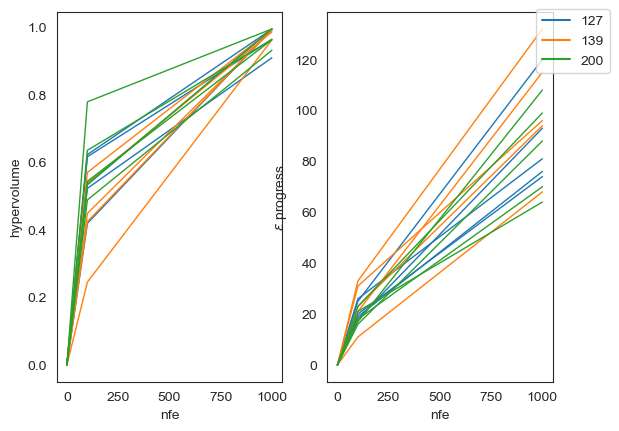

In [13]:
import matplotlib as mpl
import seaborn as sns


fig, (ax1, ax2) = plt.subplots(ncols=2)

colors = sns.color_palette()

legend_items = []
for (scenario_name, scores), color in zip(convergence.groupby("scenario"), colors):
    # we use this for a custom legend
    legend_items.append((mpl.lines.Line2D([0, 0], [1, 1], c=color), scenario_name))
    for seed, score in scores.groupby("seed"):
        ax1.plot(score.nfe, score.hypervolume, c=color, lw=1)
        ax2.plot(score.nfe, score.epsilon_progress, c=color, lw=1)


ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')

# create our custom legend
artists, labels = zip(*legend_items)
fig.legend(artists, labels, bbox_to_anchor=(1,0.9))

plt.show()

In [14]:
from ema_workbench import Policy

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:31]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)


In [15]:
for policy in policies:
    print(policy)

Policy({'0_RfR 0': 0.0, '0_RfR 1': 0.0, '0_RfR 2': 1.0, '1_RfR 0': 1.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 1.0, '2_RfR 1': 1.0, '2_RfR 2': 1.0, '3_RfR 0': 1.0, '3_RfR 1': 1.0, '3_RfR 2': 1.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 0.0, 'A.1_DikeIncrease 0': 5.0, 'A.1_DikeIncrease 1': 7.0, 'A.1_DikeIncrease 2': 7.0, 'A.2_DikeIncrease 0': 2.0, 'A.2_DikeIncrease 1': 5.0, 'A.2_DikeIncrease 2': 7.0, 'A.3_DikeIncrease 0': 0.0, 'A.3_DikeIncrease 1': 4.0, 'A.3_DikeIncrease 2': 8.0, 'A.4_DikeIncrease 0': 3.0, 'A.4_DikeIncrease 1': 4.0, 'A.4_DikeIncrease 2': 6.0, 'A.5_DikeIncrease 0': 7.0, 'A.5_DikeIncrease 1': 0.0, 'A.5_DikeIncrease 2': 0.0})
Policy({'0_RfR 0': 0.0, '0_RfR 1': 0.0, '0_RfR 2': 0.0, '1_RfR 0': 0.0, '1_RfR 1': 0.0, '1_RfR 2': 0.0, '2_RfR 0': 0.0, '2_RfR 1': 0.0, '2_RfR 2': 0.0, '3_RfR 0': 0.0, '3_RfR 1': 0.0, '3_RfR 2': 0.0, '4_RfR 0': 0.0, '4_RfR 1': 0.0, '4_RfR 2': 0.0, 'EWS_DaysToThreat': 3.0, 'A.1_DikeIncrease 0': 1.0, 'A.1_DikeIncrease 1':

In [16]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(10, policies=policies)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10 scenarios * 72 policies * 1 model(s) = 720 experiments
100%|████████████████████████████████████████| 720/720 [01:29<00:00,  8.03it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [17]:
experiments, outcomes = reeevaluation_results
# setup a dataframe for the outcomes
# we add scenario and policy as additional columns
# we need scenario because regret is calculated on a scenario by scenario basis
# we add policy because we need to get the maximum regret for each policy.
outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario
outcomes['policy'] = experiments.policy

def calculate_regret(x):
    best = x.min(numeric_only=True)
    regret = x.loc[:, best.index] - best
    regret['policy'] = x.policy
    return regret


# we want to calculate regret on a scenario by scenario basis
regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)

# as last step, we calculate the maximum regret for each policy
max_regret = regret.groupby('policy').max()

C:\Users\jhsti\AppData\Local\Temp\ipykernel_26380\1639861588.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
C:\Users\jhsti\AppData\Local\Temp\ipykernel_26380\1639861588.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
C:\Users\jhsti\AppData\Local\Temp\ipykernel_26380\1639861588.py:21: FutureWarning: The default of observed=False is deprecate

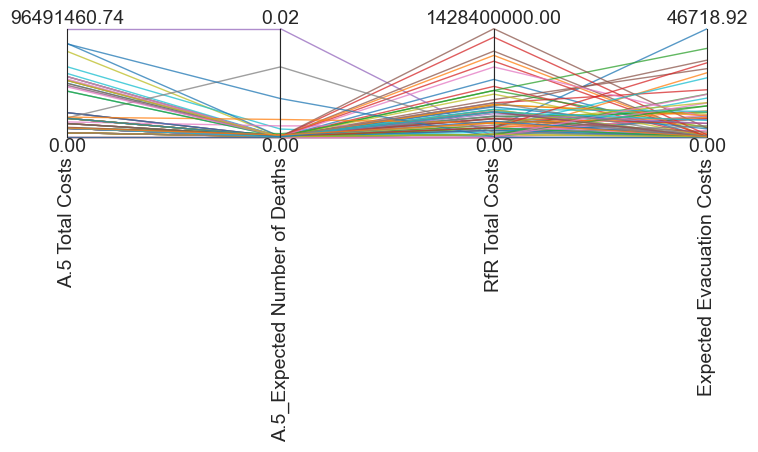

In [18]:
limits = parcoords.get_limits(max_regret)
paraxes = parcoords.ParallelAxes(max_regret)
paraxes.plot(max_regret, lw=1, alpha=0.75)

# let's resize the figure a bit
fig = plt.gcf()
fig.set_size_inches(8, 4)

plt.show()

Worst performing policies:
 ['scenario 1 option 8', 'scenario 1 option 6', 'scenario 0 option 31', 'scenario 0 option 9', 'scenario 1 option 1']
Exported numeric lever comparison with significance to 'numeric_lever_comparison_with_significance.csv'
Exported categorical distribution for scenario to 'categorical_scenario_distribution.csv'
Exported categorical distribution for model to 'categorical_model_distribution.csv'


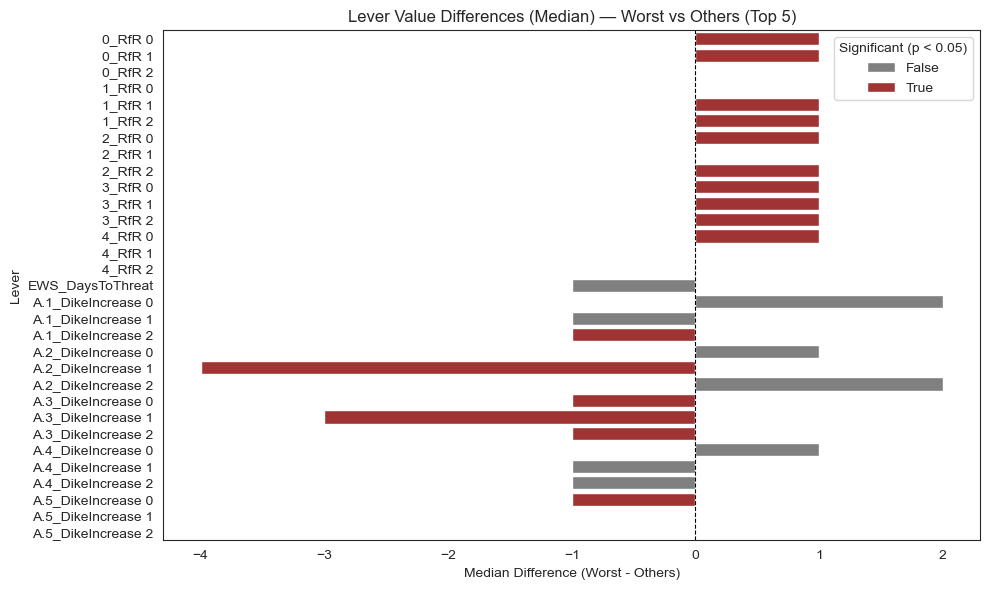

Generated barplot visualization saved as 'lever_difference_plot.png'


In [19]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

#Uncertainties to remove
uncertainties = [
    'A.1_pfail', 'A.1_Bmax', 'A.1_Brate', 'A.2_pfail', 'A.2_Bmax', 'A.2_Brate',
    'A.3_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.4_pfail', 'A.4_Bmax', 'A.4_Brate',
    'A.5_pfail', 'A.5_Bmax', 'A.5_Brate', 'discount rate 0', 'discount rate 1',
    'discount rate 2', 'A.0_ID flood wave shape'
]

#Identify worst-performing policies
top_n = 5
worst_policies = max_regret.mean(axis=1).nlargest(top_n).index.tolist()
print("Worst performing policies:\n", worst_policies)

#Filter experiments for those policies, remove uncertainties
experiments_wo_uncertainties = experiments.drop(columns=uncertainties)

#Split into worst policies and the rest
worst_policy_experiments = experiments_wo_uncertainties[experiments_wo_uncertainties['policy'].isin(worst_policies)]
other_policy_experiments = experiments_wo_uncertainties[~experiments_wo_uncertainties['policy'].isin(worst_policies)]

#Separate numeric and categorical columns
numeric_columns = experiments_wo_uncertainties.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = experiments_wo_uncertainties.select_dtypes(include=['category', 'object']).columns.drop('policy', errors='ignore').tolist()

#Compute medians of numeric levers for both groups
worst_medians = worst_policy_experiments[numeric_columns].median()
rest_medians = other_policy_experiments[numeric_columns].median()

# Perform Mann-Whitney U test for significance
p_values = {}
for col in numeric_columns:
    stat, p = mannwhitneyu(worst_policy_experiments[col], other_policy_experiments[col], alternative='two-sided')
    p_values[col] = p

# Compile results into a DataFrame
comparison_df = pd.DataFrame({
    'Worst Policies Median': worst_medians,
    'Other Policies Median': rest_medians,
    'Difference': worst_medians - rest_medians,
    'p-value': pd.Series(p_values)
})

#Flag significant differences
comparison_df['Significant (p < 0.05)'] = comparison_df['p-value'] < 0.05

#Export numeric lever comparison to CSV
comparison_df.to_csv('numeric_lever_comparison_with_significance.csv')
print("Exported numeric lever comparison with significance to 'numeric_lever_comparison_with_significance.csv'")

# 9Optional: Check categorical lever distributions
for col in categorical_columns:
    worst_counts = worst_policy_experiments[col].value_counts().rename('Worst Policies')
    rest_counts = other_policy_experiments[col].value_counts().rename('Other Policies')
    cat_comparison = pd.concat([worst_counts, rest_counts], axis=1)
    cat_comparison.to_csv(f'categorical_{col}_distribution.csv')
    print(f"Exported categorical distribution for {col} to 'categorical_{col}_distribution.csv'")

#Visualize differences with significance
plt.figure(figsize=(10, 6))
sns.barplot(
    y=comparison_df.index,
    x='Difference',
    data=comparison_df,
    hue='Significant (p < 0.05)',
    dodge=False,
    palette={True: 'firebrick', False: 'grey'}
)
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.title(f'Lever Value Differences (Median) — Worst vs Others (Top {top_n})')
plt.xlabel('Median Difference (Worst - Others)')
plt.ylabel('Lever')
plt.tight_layout()
plt.savefig('lever_difference_plot.png')
plt.show()

print("Generated barplot visualization saved as 'lever_difference_plot.png'")





In [20]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [22]:
from ema_workbench import ScalarOutcome
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
scenario 0 option 0,3.292673e-01,0.000000e+00,758100000.0,0.000000e+00
scenario 0 option 1,1.296281e+00,0.000000e+00,0.0,4.887733e+07
scenario 0 option 10,1.347515e+00,0.000000e+00,30700000.0,4.080780e+07
scenario 0 option 11,3.000622e-01,0.000000e+00,666000000.0,0.000000e+00
scenario 0 option 12,3.957302e-01,0.000000e+00,242400000.0,0.000000e+00
...,...,...,...,...
scenario 2 option 5,3.000622e-01,0.000000e+00,448200000.0,0.000000e+00
scenario 2 option 6,1.296281e+00,0.000000e+00,30700000.0,0.000000e+00
scenario 2 option 7,3.292673e-01,0.000000e+00,327000000.0,2.821942e+06
scenario 2 option 8,3.957302e-01,0.000000e+00,205800000.0,0.000000e+00


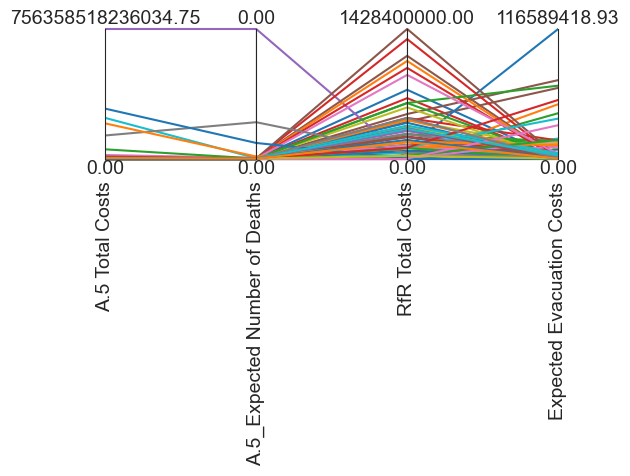

In [23]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.5 Total Costs','A.5_Expected Number of Deaths' , 'RfR Total Costs','Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()